In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os, sys
import datetime

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

processeddir = "../data/processed/"
df = pd.read_csv(os.path.join(processeddir,"nyctaxiclean.csv"), dtype={"store_and_fwd_flag": "object"})

#coerce datetimes
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
grouped_df = df.groupby("pickup_neighbourhood")


In [16]:
# for choice of order, see " examine ACF" workbook
# here we model SARIMAX using timeseries cval on 4 POC neighbourhoods - 2 busy and 2 medium

chosen_neighbourhoods = ["Upper East Side South", "Midtown Center", "Flatiron", "JFK Airport"]

df['qtr_hour'] = df['pickup_datetime'].apply(lambda x: datetime.datetime(x.year, x.month, x.day, x.hour,15*(x.minute // 15)))
arima_df = df.loc[df["pickup_neighbourhood"].isin(chosen_neighbourhoods)]


In [23]:
# model activity as number of pickups
arima_df = arima_df[["pickup_neighbourhood", "qtr_hour", "medallion"]].groupby(["pickup_neighbourhood","qtr_hour"]).count()
arima_df = arima_df.reset_index()

In [47]:
#%pdb on
# PACF indicates a model AR(1-4) with seasonality of day. Potential for MA component given damped sin effect
# ACF indicates additional seasonality component of week
# for choice of order, see " examine ACF" workbook

from statsmodels.tsa.statespace.sarimax  import SARIMAX

#time series cross validation - forecasting 1 hour at a time
#pick 4 random hours in the last week
k = 4
week_length = 7 * 24 #hours in a week
week_length_qtrs = week_length * 4 #qtr hr bins

np.random.seed(100)


best_order = (1,0,1)
best_seasonal = (1,0,1,96)

models = []
results = []
output = []
for neighbourhood in chosen_neighbourhoods:
    hours = sorted([int(np.random.random() * week_length) for x in range(4)])
    neigh_df = arima_df[arima_df["pickup_neighbourhood"]==neighbourhood]
    for hour in hours:
        test_end_idx = week_length_qtrs * 3 + hour * 4
        train_df = neigh_df["medallion"].values[:test_end_idx]
        test_df = neigh_df["medallion"].values[test_end_idx:test_end_idx+4]
        
        models.append(SARIMAX(train_df, order=best_order, seasonal_order=best_seasonal))
        results.append(models[-1].fit())

        preds = results[-1].predict(test_end_idx, test_end_idx+3) #inclusive
        
        output.append(list(zip(test_df, preds)))
        
output
        

[[(251, 208.05598598979796),
  (197, 196.0799507079503),
  (162, 187.95229493678258),
  (172, 174.8179216097823)],
 [(164, 171.97899451141112),
  (115, 155.6736107198999),
  (92, 140.3498012279402),
  (93, 122.73159417994913)],
 [(405, 400.2192622746108),
  (371, 387.5929719256551),
  (341, 342.7738332828483),
  (320, 318.469006435142)],
 [(182, 176.32989304329118),
  (180, 172.88396343682177),
  (159, 168.076936136975),
  (176, 161.17612771330056)],
 [(52, 49.85177262125542),
  (39, 31.671625028304696),
  (35, 22.874345810804478),
  (29, 11.032386962139338)],
 [(460, 471.4662398184972),
  (463, 442.8096490238564),
  (400, 450.23118194287815),
  (433, 436.34229037230307)],
 [(161, 181.38209967194788),
  (162, 161.30367318433025),
  (155, 140.49196467744645),
  (109, 128.09188185460096)],
 [(248, 263.0832721753953),
  (247, 270.4466444962168),
  (255, 281.13683228283566),
  (283, 292.2571834733625)],
 [(144, 133.0104609678498),
  (136, 127.15050781821216),
  (127, 125.97992848300154),
 

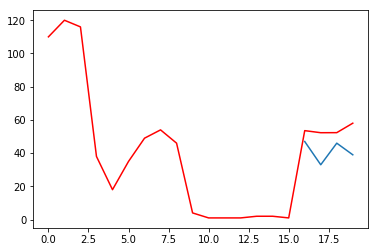

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
test_end_idx = week_length_qtrs * 3 + hours[-1] * 4
ts = neigh_df["medallion"].values[test_end_idx-16:test_end_idx]

plt.plot(np.arange(16,20), [x[0] for x in output[-5]])
plt.plot(np.arange(20), np.append(ts,[x[1] for x in output[-5]]), color='red')

In [58]:
from sklearn.metrics import mean_squared_error
import math
unpacked_preds = [x[0] for x in output]
math.sqrt(mean_squared_error([y[0] for y in unpacked_preds], [y[1] for y in unpacked_preds]))

26.635548252294868